In [5]:
import starry
import numpy as np
import starry

import jax

jax.config.update("jax_enable_x64", True)
starry.config.lazy = False

import numpy as np


from jaxoplanet.experimental.starry.light_curves import light_curve, map_light_curve
from jaxoplanet.experimental.starry.orbit import SurfaceSystem
from jaxoplanet.experimental.starry import Surface, Ylm
from jaxoplanet.orbits import keplerian
from jaxoplanet.experimental.starry import show_surface

from jaxoplanet.test_utils import assert_allclose


map = Surface(period=None, u=(1.0,))
yo = np.linspace(-3, 3, 1000)
f = map_light_curve  # jax.vmap(map_light_curve, in_axes=(None, None, None, 0, None, None))

In [6]:
ms = starry.Map(ydeg=len(map.u), udeg=len(map.u))
ms[1:] = map.u

Pre-computing some matrices... Done.
Compiling `set_vector`... Done.


In [10]:
from jaxoplanet.experimental.starry.light_curves import *


def map_light_curve(
    map,
    r: float = None,
    xo: float = None,
    yo: float = None,
    zo: float = None,
    theta: float = 0.0,
    order: int = 20,
):
    """Light curve of an occulted map.

    Args:
        map (Map): map object
        r (float or None): radius of the occulting body, relative to the current map
           body
        xo (float or None): x position of the occulting body, relative to the current
           map body
        yo (float or None): y position of the occulting body, relative to the current
           map body
        zo (float or None): z position of the occulting body, relative to the current
           map body
        theta (float): rotation angle of the map

    Returns:
        ArrayLike: flux
    """
    rT_deg = rT(map.deg)

    # no occulting body
    if r is None:
        b_rot = True
        theta_z = 0.0
        x = rT_deg

    # occulting body
    else:
        b = jnp.sqrt(jnp.square(xo) + jnp.square(yo))
        b_rot = jnp.logical_or(jnp.greater_equal(b, 1.0 + r), jnp.less_equal(zo, 0.0))
        b_occ = jnp.logical_not(b_rot)
        theta_z = jnp.arctan2(xo, yo)
        sT = solution_vector(map.deg, order)(b, r)

        # scipy.sparse.linalg.inv of a sparse matrix[[1]] is a non-sparse [[1]], hence
        # `from_scipy_sparse`` raises an error (case deg=0)
        if map.deg > 0:
            A2 = scipy.sparse.linalg.inv(A2_inv(map.deg))
            A2 = jax.experimental.sparse.BCOO.from_scipy_sparse(A2)
        else:
            A2 = jnp.array([1])

        x = jnp.where(b_occ, sT @ A2, rT_deg)

    # TODO(lgrcia): Is this the right behavior when map.y is None?
    if map.y is None:
        rotated_y = jnp.zeros(map.ydeg)
    else:
        rotated_y = left_project(
            map.ydeg, map.inc, map.obl, theta, theta_z, map.y.todense()
        )

    # limb darkening
    U = jnp.array([1, *map.u])
    A1_val = jax.experimental.sparse.BCOO.from_scipy_sparse(A1(map.ydeg))
    p_y = Pijk.from_dense(A1_val @ rotated_y, degree=map.ydeg)
    p_u = Pijk.from_dense(U @ U0(map.udeg), degree=map.udeg)
    p_y = p_y * p_u

    norm = np.pi / (p_u.tosparse() @ rT(map.udeg))

    return (p_y.tosparse() @ x) * norm


f = jax.jit(
    jax.vmap(map_light_curve, in_axes=(None, None, None, 0, None, None, None)),
    static_argnames=("order"),
)

In [11]:
ms.flux(ro=0.1, yo=0.1, xo=0.0, zo=10.0)
f(map, 0.1, 0.0, np.array([0.1]), 10.0, 0.0, 500)

Array([0.98511313], dtype=float64)

In [13]:
from tqdm import tqdm

n = 500
r = np.linspace(0, 2, n)
b = np.linspace(0, 2, n)

ro = 0.5

R, B = np.meshgrid(r, b)

result = np.zeros_like(R)

for i, _r in enumerate(tqdm(r)):
    try:
        calc = f(map, _r, 0.0, b, 10.0, 0.0, 20)
        expected = ms.flux(ro=_r, yo=b, xo=0.0, zo=10.0)
        result[i, :] = calc - expected
    except:
        print(_r)

100%|██████████| 500/500 [00:00<00:00, 1003.34it/s]


Text(0, 0.5, 'b')

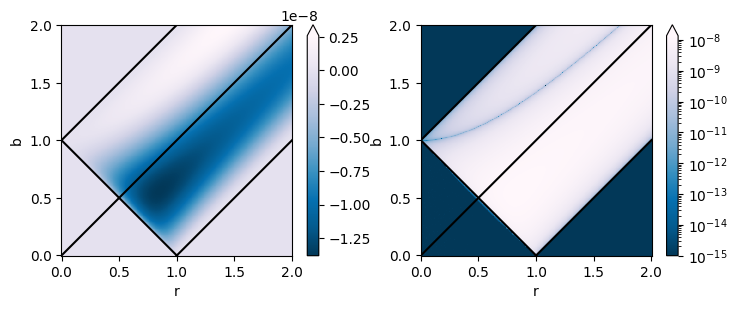

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

fig = plt.figure(figsize=(8.5, 3))
ax = plt.subplot(121)

all_result = result.copy()
all_result[result == 0] = 1e-20

pcm = ax.pcolor(
    R,
    B,
    # np.abs(all_result).T,
    # norm=colors.LogNorm(vmin=1e-15, vmax=1e-7),
    all_result.T,
    cmap="PuBu_r",
    shading="auto",
)
fig.colorbar(pcm, ax=ax, extend="max")

# aspect ratio
ax.set_aspect("equal", "box")
plt.axline((0, 0), slope=1, color="k", linestyle="-")
plt.axline((1, 0), slope=1, color="k", linestyle="-")
plt.axline((0, 1), slope=1, color="k", linestyle="-")
plt.axline((0, 1), slope=-1, color="k", linestyle="-")

plt.xlabel("r")
plt.ylabel("b")

ax = plt.subplot(122)

pcm = ax.pcolor(
    R,
    B,
    np.abs(all_result).T,
    norm=colors.LogNorm(vmin=1e-15, vmax=np.abs(all_result).max()),
    # all_result.T,
    cmap="PuBu_r",
    shading="auto",
)
fig.colorbar(pcm, ax=ax, extend="max")

# aspect ratio
ax.set_aspect("equal", "box")
plt.axline((0, 0), slope=1, color="k", linestyle="-")
plt.axline((1, 0), slope=1, color="k", linestyle="-")
plt.axline((0, 1), slope=1, color="k", linestyle="-")
plt.axline((0, 1), slope=-1, color="k", linestyle="-")

plt.xlabel("r")
plt.ylabel("b")

In [21]:
f = jax.jit(
    jax.vmap(map_light_curve, in_axes=(None, None, None, 0, None, None, None)),
    static_argnames=("order"),
)

%timeit f(map, _r, 0.0, b, 10.0, 0.0, 500)

In [16]:
%timeit ms.flux(ro=_r, yo=b, xo=0.0, zo=10.0)

202 µs ± 6.72 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [47]:
result

array([[-3.33066907e-16, -3.33066907e-16, -3.33066907e-16, ...,
        -3.33066907e-16, -3.33066907e-16, -3.33066907e-16],
       [ 0.00000000e+00,  2.22044605e-16, -2.22044605e-16, ...,
        -3.33066907e-16, -3.33066907e-16, -3.33066907e-16],
       [ 2.22044605e-16, -4.44089210e-16,  2.22044605e-16, ...,
        -3.33066907e-16, -3.33066907e-16, -3.33066907e-16],
       ...,
       [-7.51790282e-17, -7.51790282e-17, -7.51790282e-17, ...,
        -1.93178806e-14, -1.88737914e-14, -1.89848137e-14],
       [-7.51790282e-17, -7.51790282e-17, -7.51790282e-17, ...,
        -1.86517468e-14, -1.93178806e-14, -1.97619698e-14],
       [-7.51790282e-17, -7.51790282e-17, -7.51790282e-17, ...,
        -2.03170814e-14, -1.94289029e-14, -1.93178806e-14]])

In [8]:
plt.show(result, extent=(r.min(), r.max(), b.min(), b.max()))
plt.colorbar()

ValueError: data type <class 'numpy.int64'> not inexact

In [12]:
map_light_curve(map, ro, b, 0.0, 2.0, 0.0)

NameError: name 'ro' is not defined

In [6]:
import matplotlib.pyplot as plt


calc = map_light_curve(map, 0.1, 0.0, 0.0, 2.0, 0.0)
expected = ms.flux(xo=0.0, yo=0.0, ro=0.1, zo=2.0)

In [8]:
np.abs(calc - expected)

array([9.99200722e-16])

In [105]:
def show(r, b):
    ax = plt.subplot(121)
    disk_star = plt.Circle((0, 0), 1, fill=False, ec="k", lw=2)
    disk_occultor = plt.Circle((b, 0), r, fill=True, fc="k", ec="k", lw=2)
    ax.add_artist(disk_star)
    ax.add_artist(disk_occultor)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect("equal", "box")

    ax = plt.subplot(122)
    ax.axline((0, 0), slope=1, color="k", linestyle="-")
    ax.axline((1, 0), slope=1, color="k", linestyle="-")
    ax.axline((0, 1), slope=1, color="k", linestyle="-")
    ax.axline((0, 1), slope=-1, color="k", linestyle="-")
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.plot(r, b, "x", color="k")
    ax.set_aspect("equal", "box")

    pcm = ax.pcolor(
        R,
        B,
        np.abs(all_result).T,
        norm=colors.LogNorm(vmin=1e-15, vmax=np.abs(all_result).max()),
        # all_result.T,
        cmap="PuBu_r",
        shading="auto",
    )
    fig.colorbar(pcm, ax=ax, extend="max")
    plt.xlabel("r")
    plt.ylabel("b")

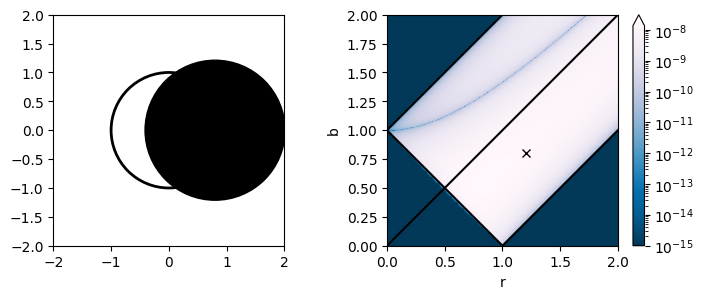

In [107]:
fig = plt.figure(figsize=(8.5, 3))
show(1.2, 0.8)

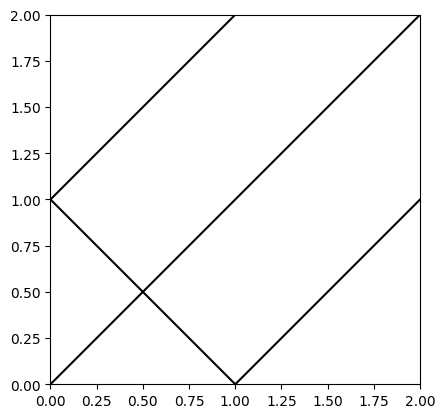

In [86]:
plt.axline((0, 0), slope=1, color="k", linestyle="-")
plt.axline((1, 0), slope=1, color="k", linestyle="-")
plt.axline((0, 1), slope=1, color="k", linestyle="-")
plt.axline((0, 1), slope=-1, color="k", linestyle="-")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.gca().set_aspect("equal", "box")